In [1]:
# coding: UTF-8
%matplotlib inline
import glob
import os
import sys
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from __future__ import print_function
import keras
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
dataset = "ModelNet10"  #or "ModelNet40"
n_points = 4096

In [33]:
if dataset == "ModelNet10":
    data_dir = "ModelNet10/"
    save_dir = "data10/"
    num_classes = 10
    class_name_modelnet = [
    'bathtub',
    'chair',
    'dresser',
    'night_stand',
    'table',
    'bed',
    'desk',
    'monitor',
    'sofa',
    'toilet',
    ]

In [4]:
if dataset == "ModelNet40":
    data_dir = "ModelNet40/"
    save_dir = "data40/"
    num_classes = 40
    class_name_modelnet = [
    'airplane',
    'bookshelf',
    'chair',
    'desk',
    'glass_box',
    'laptop',
    'person',
    'range_hood',
    'stool',
    'tv_stand',
    'bathtub',
    'bottle',
    'cone',
    'door',
    'guitar',
    'mantel',
    'piano',
    'sink',
    'table',
    'vase',
    'bed',
    'bowl',
    'cup',
    'dresser',
    'keyboard',
    'monitor',
    'plant',
    'sofa',
    'tent',
    'wardrobe',
    'bench',
    'car',
    'curtain',
    'flower_pot',
    'lamp',
    'night_stand',
    'radio',
    'stairs',
    'toilet',
    'xbox',
    ]

In [5]:
train_or_test = ["train","test"]

In [6]:
def load_off(filename):
    # read OFF file
    with open(filename,"r") as handle:
        off = handle.read().rstrip().split("\n")
        
    #OFFファイルが不正かどうか判定
    if off[0] != "OFF":
        print("{} is broken!!".format(filename))
        
        return "ERROR","ERROR"
    
    
    else:
        #get params and faces
        params = list(map(int, off[1].split(" ")))
        n_vertices = params[0]
        n_faces = params[1]

        # read  Vertex coordinates
        vertices = []
        for n in range(n_vertices):
            coords = list(map(float, off[2+n].split()))
            vertices.append(coords)

        # read information of faces
        faces = []
        for n in range(n_faces):
            connects = list(map(int, off[2 + n_vertices + n].split(" ")))[1:]
            faces.append(connects)

        return vertices, faces


In [7]:
def calc_vector_norm(a):
#     何も分からん
    norm = 0.0
    for el in a:
        norm += el *el
    return math.sqrt(norm)

In [8]:
def calc_cross_product_3d(a,b):
#     なんもわからん
    return [a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2],a[0]*b[1]-a[1]*b[0]]

In [9]:
def calc_triangle_area(a, b, c):
#     なんもわからん
    ca = [c[0]-a[0], c[1]-a[1], c[2]-a[2]]
    ba = [b[0]-a[0], b[1]-a[1], b[2]-a[2]]
    cross = calc_cross_product_3d(ca, ba)
    return 0.5 * calc_vector_norm(cross)

In [10]:
def calc_cumulative_areas(vertices, faces):
#     なんもわからん
    cuma = 0.0
    cum_areas = []
    for fc in faces:
        cuma += calc_triangle_area(
            vertices[fc[0]], vertices[fc[1]], vertices[fc[2]])
        cum_areas.append(cuma)
    return cum_areas

In [11]:
def random_select_face_id(cum_areas):
#     なんもわからん
    rand_area = cum_areas[-1] * random.random()
    select_id = 0
    for n in range(len(cum_areas)):
        if rand_area <= cum_areas[n]:
            select_id = n
            break
    return select_id

In [12]:
def gen_random_points(vertices, faces, n_points):
#     なんもわからん
    cum_areas = calc_cumulative_areas(vertices, faces)
    points = []
    for n in range(n_points):
        fid = random_select_face_id(cum_areas)
        r1 = math.sqrt(random.random())
        r2 = random.random()
        a = vertices[faces[fid][0]]
        b = vertices[faces[fid][1]]
        c = vertices[faces[fid][2]]
        xp = (1 - r1) * a[0] + r1 * (1 - r2) * b[0] + r1 * r2 * c[0]
        yp = (1 - r1) * a[1] + r1 * (1 - r2) * b[1] + r1 * r2 * c[1]
        zp = (1 - r1) * a[2] + r1 * (1 - r2) * b[2] + r1 * r2 * c[2]
        points.append([xp, yp, zp])
    return points

In [13]:
def plot3D(np_pc):
    #3D表示
    fig = plt.figure(1,figsize=(10, 10))
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(np_pc[:,0], np_pc[:,1], np_pc[:,2])
    ax.axis("equal")
    plt.show()

In [14]:
def plot_trihedral_figure_vox(np_pc):
    #Voxel版三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=10)
        plt.xlim([-2,32]) 
        plt.ylim([-2,32]) 
        plt.gca().set_aspect('equal')
        plt.show()

In [15]:
def plot_trihedral_figure(np_pc):
    #三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=2)
        plt.axis('equal')
        plt.show()

In [16]:
def voxilize(np_pc):
# ボクセル化した配列を返す
    max_dist = 0.0
    for it in range(0,3):
        # 最大値と最小値の距離を求める
        min = np.amin(np_pc[:,it])
        max = np.amax(np_pc[:,it])
        dist = max-min

        #xyzで一番並行距離が大きいのを求める
        if dist > max_dist:
            max_dist = dist
            
    for it in range(0,3):

        # 最大値と最小値の距離を求める
        min = np.amin(np_pc[:,it])
        max = np.amax(np_pc[:,it])
        dist = max-min
        
        #中心座標を 0,0,0にセットする（原点が中心にくるようにする）
        np_pc[:,it] = np_pc[:,it] - dist/2 - min

        #covered cells
        cls = 29

        #ボクセル一個当たりのサイズを求める
        vox_sz = max_dist/(cls-1)

        #上で算出した値で各点を割る。これで各点は(-14, 14)の範囲の値になる
        np_pc[:,it] = np_pc[:,it]/vox_sz

        #各点が全て正の整数になるよう移動。これで各点は[0, 30]になる（多分）
        np_pc[:,it] = np_pc[:,it] + (cls-1)/2


    #整数にする
    np_pc = np.rint(np_pc).astype(np.uint32)


    #３０＊３０＊３０の配列を作り，点が存在する場合は1、存在しない場合は0を入力する。
    vox = np.zeros([30,30,30])

    # (pc_x, pc_y, pc_z)にnp_pcの座標を代入する
    for (pc_x, pc_y, pc_z) in np_pc:

    # 点が存在しても20%の確率で0とし、データにノイズを加え、汎用性を上げている
    # ここ，ノイジーなデータの場合８０よりも小さい数字にしたほうがいいかもね？
        if random.randint(0,100) < 80:
            vox[pc_x, pc_y, pc_z] = 1

    np_vox = np.zeros([1,1,32,32,32])
    np_vox[0, 0, 1:-1, 1:-1, 1:-1] = vox

    return np_vox

In [17]:
def voxel_scatter(np_vox):
# キレイに整形するやつ
    #空の配列を作る
    vox_scat = np.zeros([0,3], dtype= np.uint32)

    #32回
    for x in range(0,np_vox.shape[2]):
        #32回
        for y in range(0,np_vox.shape[3]):
            #32回
            for z in range(0,np_vox.shape[4]):
                #（ｘ，ｙ，ｚ）に１が入っていればその座標を返す
                if np_vox[0,0,x,y,z] == 1.0:
                    arr_tmp = np.zeros([1,3],dtype=np.uint32)
                    arr_tmp[0,:] = (x,y,z)
                    vox_scat = np.concatenate((vox_scat,arr_tmp))
    return vox_scat

In [18]:
def load_vox(filename):
    #shape(N,1,32,32,32)の配列を返す
    vertices, faces = load_off(filename)
    if vertices == "ERROR":
        return "ERROR"
        
    else:
        points = gen_random_points(vertices, faces, n_points)
        # ValueError: sequence too large; cannot be greater than 32の回避策
        # list 2 numpy.ndarray
        pc = np.empty((len(points), len(points[0])))
        pc[:] = points
        vox = voxilize(pc)

        return vox

In [19]:
#  ====================rename===============================
for cl in class_name_modelnet:
    print('Renameing {} files ...'.format(cl))
    for t in train_or_test:
        i = 0
        #ファイル名を取得
        namelist = glob.glob(data_dir+ cl +"/" + t + "/*")
        if data_dir+ cl +"/" + t + "/0.off" in namelist:
            print(t +" is already renamed!!")
            continue
        for file in namelist:
            os.rename(file, data_dir+ cl +'/' + t +"/"+ str(i) + '.off')
            i+=1
print("Rename all!")
#  ====================rename===============================

Renameing bathtub files ...
train is already renamed!!
test is already renamed!!
Renameing chair files ...
train is already renamed!!
test is already renamed!!
Renameing dresser files ...
train is already renamed!!
test is already renamed!!
Renameing night_stand files ...
train is already renamed!!
test is already renamed!!
Renameing table files ...
train is already renamed!!
test is already renamed!!
Renameing bed files ...
train is already renamed!!
test is already renamed!!
Renameing desk files ...
train is already renamed!!
test is already renamed!!
Renameing monitor files ...
train is already renamed!!
test is already renamed!!
Renameing sofa files ...
train is already renamed!!
test is already renamed!!
Renameing toilet files ...
train is already renamed!!
test is already renamed!!
Rename all!


In [20]:
# demo
vertices, faces = load_off(data_dir+"bathtub/test/0.off")
points = gen_random_points(vertices, faces, n_points)

In [21]:
# ValueError: sequence too large; cannot be greater than 32の回避策
# list 2 numpy.ndarray
test = np.empty((len(points), len(points[0])))
test[:] = points
print(type(test))


<class 'numpy.ndarray'>


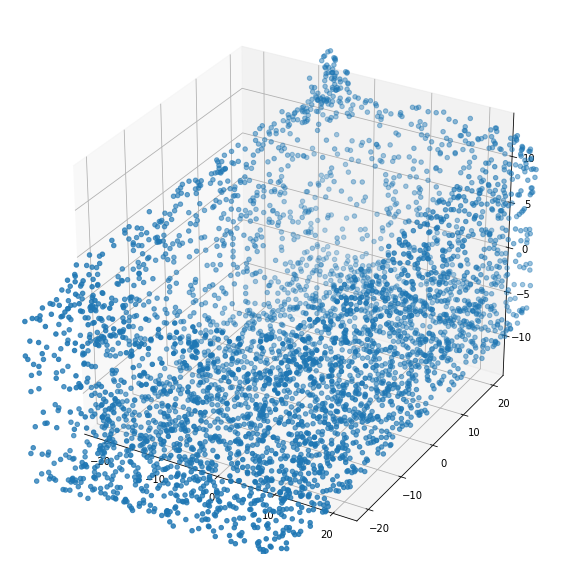

In [22]:
plot3D(test)

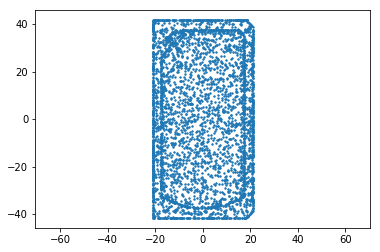

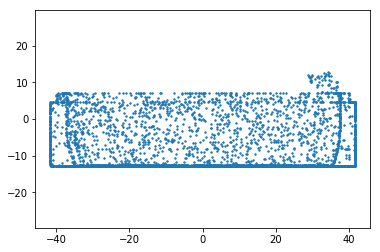

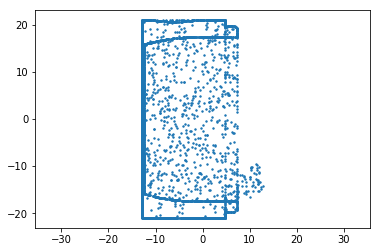

In [23]:
plot_trihedral_figure(test)

In [24]:
#voxelize
test_vox = voxilize(test)

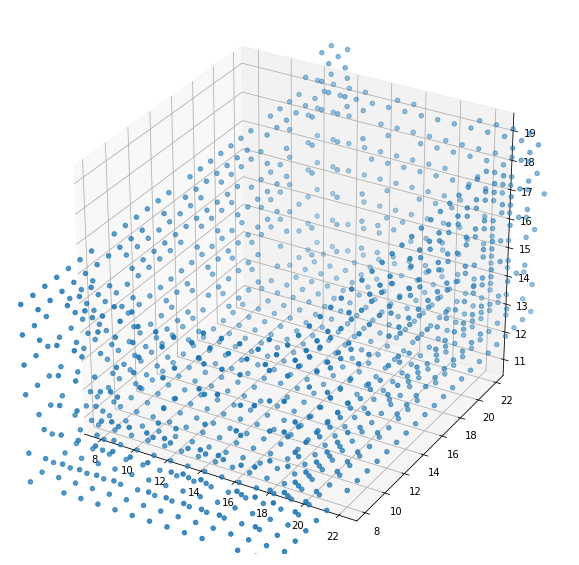

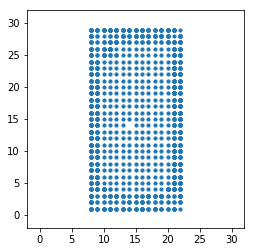

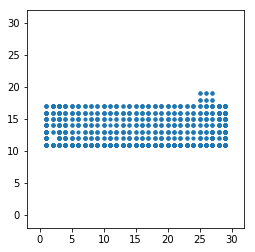

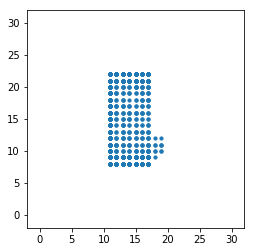

In [25]:
#turn
vox_scat = voxel_scatter(test_vox)
plot3D(vox_scat)
plot_trihedral_figure_vox(vox_scat)

In [26]:
test_vox.shape

(1, 1, 32, 32, 32)

In [27]:
if os.path.exists(save_dir) == False:
    os.mkdir(save_dir)

In [29]:
for t in train_or_test:
    for cl in  tqdm(class_name_modelnet):
        print(cl)
        num = glob.glob(data_dir+ cl +"/" + t + "/*")
        for i in tqdm(range(len(num))):
            if i ==0  :
                off = load_vox(data_dir + cl + "/" + t +"/"+ str(i) + ".off")
                continue
            off_ =  load_vox(data_dir + cl + "/" + t +"/"+ str(i) + ".off")
            
            #エラー回避
            if off_ == "ERROR" or off == "ERROR":
                continue
                
            off = np.append(off, off_, axis=0)
        np.save(save_dir + cl + t + ".npy", off)
#クラス毎，TestTrain毎ボクセル化されたnpzが生成される（N,1,32,32,32）

A Jupyter Widget

bathtub


A Jupyter Widget

/home/takitani/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


chair


A Jupyter Widget

KeyboardInterrupt: 

In [34]:


for t in train_or_test:
    swich_npy = True 
    num_of_data = []#init
    for cl in class_name_modelnet:
        if swich_npy == True:
            npy = np.load(save_dir  + cl + t + ".npy")
            num_of_data.append(npy.shape[0])
            swich_npy = False
        else:
            npy_ = np.load(save_dir  + cl + t + ".npy")
            npy = np.append(npy,npy_,axis=0)
            num_of_data.append(npy_.shape[0])
    if t == "train":
        x_train = npy
        y_train = num_of_data
    if t == "test":
        x_test = npy
        y_test = num_of_data

In [35]:
for t in train_or_test:
    if t == "train":
        for i in range(num_classes):
            if i == 0:
                label = np.full(y_train[i] , i )    
            else:
                label_ = np.full(y_train[i] , i )   
                label = np.append(label, label_, axis=0)
        y_train = label

    if t == "test":
        for i in range(num_classes):
            if i == 0:
                label = np.full(y_test[i] , i )    
            else:
                label_ = np.full(y_test[i] , i )   
                label = np.append(label, label_, axis=0)
        y_test = label

In [36]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [37]:
np.save(save_dir + "x_train.npy",x_train)
np.save(save_dir + "x_test.npy",x_test)
np.save(save_dir + "y_train.npy",y_train)
np.save(save_dir + "y_test.npy",y_test)